In [10]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import k3d
import seaborn as sns
from sklearn.cluster import KMeans
from datasets import ShapeNetDataset, PointCloudNormalize
from torch.utils.data import DataLoader
from collections import defaultdict
from joblib import Parallel, delayed
from faiss import Kmeans, PCAMatrix
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

In [2]:
def convert_labels(patch_labels, point_labels, mapping):
    labels = np.zeros_like(point_labels)

    for (sample_idx, patch_idx), patch_label in zip(mapping, patch_labels):
        labels[sample_idx][point_labels[sample_idx] == patch_idx] = patch_label

    return labels


def cluster(k_range, features):
    def worker(k, features):
        clt = Kmeans(features.shape[1], k, niter=200, nredo=3, spherical=False, seed=0)
        clt.train(features)
        _, labels = clt.index.search(features, 1)
        return clt.centroids, labels[:, 0]
    
    results = Parallel(n_jobs=120, backend='threading', verbose=True)(delayed(worker)(k, features)
                                                            for k in k_range)
    
    return results


def calc_iou(loader, points_labels):
    cls_partset = defaultdict(lambda: set())
    
    for (_, inst_label), labels in tqdm(zip(loader, points_labels), total=len(points_labels)):
        cls_partset[inst_label] |= set(labels)
        
    n_classes = len(cls_partset)
    ious = np.zeros((n_classes, n_classes))
    
    for i, parts1 in enumerate(cls_partset.values()):
        for j, parts2 in enumerate(cls_partset.values()):
            ious[i, j] = len(parts1 & parts2) / len(parts1 | parts2)
            
    unique_pairs = (n_classes - 1) * n_classes / 2
    mean_score = np.triu(ious, k=1).sum() / unique_pairs   
    return ious, mean_score

In [3]:
category2synset = {
    'airplane': '2691156',
    'ashcan': '2747177',
    'bag': '2773838',
    'basket': '2801938',
    'bathtub': '2808440',
    'bed': '2818832',
    'bench': '2828884',
    'birdhouse': '2843684',
    'bookshelf': '2871439',
    'bottle': '2876657',
    'bowl': '2880940',
    'bus': '2924116',
    'cabinet': '2933112',
    'camera': '2942699',
    'can': '2946921',
    'cap': '2954340',
    'car': '2958343',
    'chair': '3001627',
    'clock': '3046257',
    'computer keyboard': '3085013',
    'dishwasher': '3207941',
    'display': '3211117',
    'earphone': '3261776',
    'faucet': '3325088',
    'file': '3337140',
    'guitar': '3467517',
    'helmet': '3513137',
    'jar': '3593526',
    'knife': '3624134',
    'lamp': '3636649',
    'laptop': '3642806',
    'loudspeaker': '3691459',
    'mailbox': '3710193',
    'microphone': '3759954',
    'microwave': '3761084',
    'motorcycle': '3790512',
    'mug': '3797390',
    'piano': '3928116',
    'pillow': '3938244',
    'pistol': '3948459',
    'pot': '3991062',
    'printer': '4004475',
    'remote control': '4074963',
    'rifle': '4090263',
    'rocket': '4099429',
    'skateboard': '4225987',
    'sofa': '4256520',
    'stove': '4330267',
    'table': '4379243',
    'telephone': '4401088',
    'cellular telephone': '2992529',
    'tower': '4460130',
    'train': '4468005',
    'vessel': '4530566',
    'washer': '4554684'
}

In [4]:
data = np.load('../../datasets/shapenet_sym.npz')
dataset = ShapeNetDataset('../../datasets/hdfs/shapenet.h5', ['train', 'val', 'test'], ['all'])

In [5]:
list(data.keys())

['points_local_labels', 'patch_embeddings', 'patch_points_map']

In [6]:
k_range = list(range(20, 105, 5))
clt_results = cluster(k_range, data['patch_embeddings'])

[Parallel(n_jobs=120)]: Using backend ThreadingBackend with 120 concurrent workers.
[Parallel(n_jobs=120)]: Done  12 out of  17 | elapsed:  1.0min remaining:   25.3s
[Parallel(n_jobs=120)]: Done  17 out of  17 | elapsed:  1.1min finished


In [7]:
points_labels_set = []

for _, patch_labels in tqdm(clt_results):
    l = convert_labels(patch_labels, data['points_local_labels'], data['patch_points_map'])
    points_labels_set.append(l)

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
metrics = [calc_iou(dataset, labels) for labels in points_labels_set]
ious, mean_scores = list(map(list, zip(*metrics)))

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

  0%|          | 0/52396 [00:00<?, ?it/s]

<AxesSubplot:>

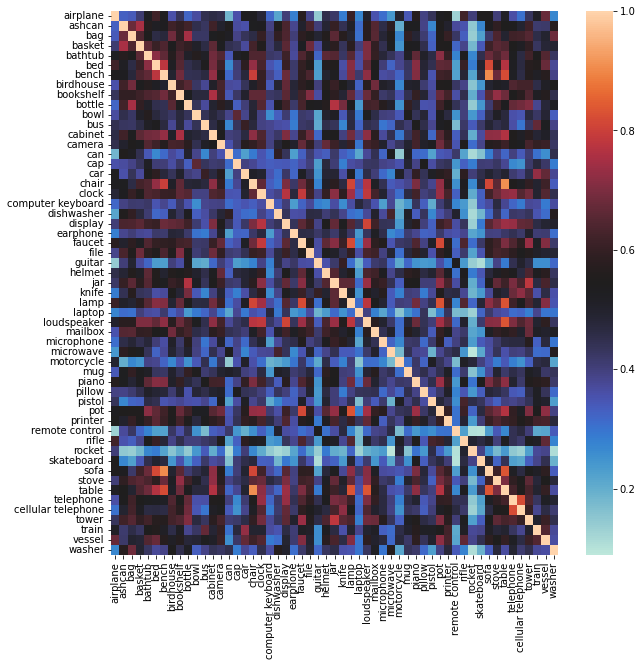

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(ious[-1],
            xticklabels=category2synset.keys(),
            yticklabels=category2synset.keys(),
            cmap=sns.color_palette("icefire", as_cmap=True))

In [10]:
centroids, patch_labels = list(map(list, zip(*clt_results)))
points_labels_set = np.array(points_labels_set)

In [11]:
with h5py.File('../../datasets/shapenet_labels_global.h5', 'w') as f:
    start_idx = 0
    f.create_dataset('k_range', data=np.array(k_range), dtype='i4', compression='gzip')
    f.create_dataset('patch_embeddings', data=data['patch_embeddings'], dtype='f4', compression='gzip')
    f.create_dataset('patch_labels', data=np.array(patch_labels), dtype='i4', compression='gzip')
    f.create_dataset('scores', data=mean_scores, dtype='f4', compression='gzip')
    
    for split in ('train', 'val', 'test'):
        group = f.create_group(split)
        split_size = dataset.split_sizes[split]
        end_idx = start_idx + split_size
        
        group.create_dataset('global_labels', data=points_labels_set[:, start_idx:end_idx],
                             dtype='i4', compression='gzip')
        
        group.create_dataset('local_labels', data=data['points_local_labels'][start_idx:end_idx],
                             dtype='i4', compression='gzip')
        
        start_idx = end_idx

In [3]:
f = h5py.File('../../datasets/shapenet_labels_global.h5', 'r')

In [4]:
dataset = ShapeNetDataset('../../datasets/hdfs/shapenet.h5', ['train', 'test'], ['all'],
                          points_labels_path='../../datasets/shapenet_labels_global.h5',
                          point_labels_level='global', n_classes=40)

In [7]:
p, l = dataset[35000]

In [8]:
k3d.points(p.T, attribute=l, point_size=0.01)

Output()

In [62]:
set(l)

{4, 19, 32, 37}

In [16]:
patch_embeddings = f['patch_embeddings'][:40000]

In [17]:
patch_labels = f['patch_labels'][0, :40000]

In [38]:
def prepare_queue_initialization(patch_embeddings, patch_labels, size_per_cls, emb_dim):
    pca = PCAMatrix(patch_embeddings.shape[1], emb_dim)
    pca.train(patch_embeddings)
    patch_embeddings = pca.apply_py(patch_embeddings)
    labels = np.unique(patch_labels)
    data = []

    for l in labels:
        embs = patch_embeddings[patch_labels == l]
        embs_size = embs.shape[0]
        if embs_size < size_per_cls:
            print(embs_size)
            pad_size = size_per_cls - embs.shape[0]
            pad = np.random.randn(pad_size, emb_dim)
            embs = np.concatenate((embs, pad), axis=0)
        elif embs_size > size_per_cls:
            perm = np.random.permutation(embs_size)[:size_per_cls]
            embs = embs[perm]

        data.append(embs)

    data = np.array(data)

    return torch.from_numpy(data)

In [39]:
init = prepare_queue_initialization(patch_embeddings, patch_labels, 1000, 128)

119
777
685
730
351
530


In [41]:
init.shape

torch.Size([20, 1000, 128])

In [27]:
from collections import Counter

In [28]:
c = Counter()
c.update(patch_labels)

In [34]:
40000 / np.median(list(c.values()))

26.872690628149144